# Text Segmentation
Si richiede un'implementazione di un sistema di text segmentation, prendendo ispirazione da TextTiling. In particolare, partendo da un corpus composto da almeno 3 sezioni su tematiche molto diverse (ad es. potete usare paragrafi da tre pagine di Wikipedia diverse), dovrete testare il vostro sistema in modo che riesca ad individuare le giuste linee di taglio (o quasi).
Articoli recuperati da: 
- https://en.wikipedia.org/wiki/Shanghai_Trolleybus_Route_20
- https://en.wikipedia.org/wiki/Pasta_primavera
- https://en.wikipedia.org/wiki/United_States 

In [7]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import numpy as np
from scipy.spatial.distance import cosine
from collections import Counter
from statistics import mean
from math import floor
from itertools import starmap, combinations
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

### Algoritmo
1. Preelaborazione del testo, che include tokenizzazione e lemmatizzazione, nonché rimozione delle stopwords e della punteggiatura.
2. Espansione dei dati di testo utilizzando i synset di WordNet.
3. Calcolo delle matrici di similarità.
4. Utilizzo di un approccio a finestra scorrevole per identificare i punti ottimali di segmentazione del testo.

La segmentazione basata sulla similarità del testo è un approccio ampiamente utilizzato e l'algoritmo TextTiling di Hearst è uno dei metodi popolari per la segmentazione del testo. Questo approccio si basa sulla misura della similarità tra le frasi per individuare i punti di cambio di argomento o tematica nel testo.

Nel codice fornito, non è stata completamente implementata un'intera versione dell'algoritmo TextTiling, ma sono stati selezionati alcuni elementi e testati. L'idea di espandere le frasi utilizzando i synset di WordNet suggerisce l'importanza di considerare le somiglianze semantiche tra le frasi per una segmentazione più significativa del testo.


### Pre-elaborazione ed Espansione dei dati di testo utilizzando i synset di WordNet.

L'espansione delle informazioni nel preprocessamento del testo è una tecnica che mira a arricchire il testo originale incorporando definizioni ed esempi associati alle frasi. Ciò può migliorare la comprensione del testo, considerare le relazioni semantiche tra le frasi, migliorare la coerenza e l'accuratezza, nonché sfruttare risorse linguistiche esistenti come WordNet. 
Di contro, però:
- Complessità spaziale:: L'espansione delle informazioni può aumentare significativamente la dimensione complessiva del testo. Ciò potrebbe essere problematico se si lavora con grandi quantità di dati o se si ha una limitazione sulle risorse di memoria.
- Rischi di informazioni errate: Se le definizioni o gli esempi estratti da WordNet o altre fonti linguistiche non sono accurati o rilevanti nel contesto specifico, l'espansione delle informazioni potrebbe introdurre informazioni errate o fuorvianti nel testo.

- Complessità computazionale: L'elaborazione delle definizioni ed esempi richiede l'accesso a risorse linguistiche esterne, come WordNet, e l'esecuzione di operazioni di ricerca e recupero dei dati. Ciò può aumentare la complessità computazionale del processo di preprocessamento del testo. Il problema è infatti che l'accesso a queste strutture non è parallelizzabile..

In [8]:
from nltk.wsd import lesk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()


nltk.download('punkt')
nltk.download('stopwords')
stopwords_set= stopwords.words('english')
punctuation = set(string.punctuation)
def read_article(path):
    with open(path, 'r', encoding='utf-8') as f:
        article = f.read()
        paragraphs = article.split('\n')
        paragraphs = [x for x in paragraphs if x.strip() != ''][1:]
        sentences = sent_tokenize(article)[1:]
        return sentences, paragraphs

def preprocess_data(sentence):
    words = nltk.word_tokenize(sentence.lower())
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Specify the part-of-speech tag 'v' for verb
    words = [word for word in words if word not in stopwords_set]
    words = [word for word in words if word not in punctuation]
    return words

def calculate_word_frequencies(sentences):
   
    freqs = Counter()
    # For each sentence in the list, calculate the word frequencies and add them to freqs
    for sentence in sentences:
        words = preprocess_data(sentence)
        freqs += Counter(words)
    # Return freqs
    return freqs

def disambiguate_senses(sentence):

    words = preprocess_data(sentence)
    # Disambiguate the senses of the words
    senses = [lesk(context_sentence=words, ambiguous_word=word) for word in words]
    # Remove None values
    senses = [sense for sense in senses if sense is not None]
    # Return a Counter object of the senses
    return Counter(senses)

def preprocess(sentence, use_synsets=True):
    sentences = [sentence]
    if use_synsets:
        for x in sentence:
            for synset,count in disambiguate_senses(x).most_common(1):
                sentences.append(synset.definition())
                sentences.extend(synset.examples())
    context = calculate_word_frequencies(sentences)
    return Counter(context)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Calcolo delle matrici di similarità.
Nel Text Tiling, vengono calcolate le matrici di similarità tra le sezioni di testo per identificare le transizioni tematiche. 
La scelta di utilizzare l'IDF (Inverse Document Frequency) è motivata dal desiderio di penalizzare le frasi comuni e favorire quelle più rare. Ciò è utile per dare maggiore peso alle frasi che potrebbero essere indicative di un cambio di argomento o tematica.
Ovviamente la metrica di similarità utilizzata è la cosin similarity.

nota: computer_sim_matrix crea una matrice di "similarità tra concetti contenuti in coppie di frasi".


In [9]:
# similarity between any 2 sentences
def compute_similarity_matrix(sentences):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)
    return cosine_similarity(X)


def find_avg_similarity(vectors, similarity_function):
    return mean(starmap(similarity_function, combinations(vectors, 2)))

def window_similarity(window, similarity_func=lambda x, y: 1 - cosine(x, y)):
    vectors = [x for x in window.T]
    return find_avg_similarity(vectors, similarity_func)

# rolling window similarity for a given similarity matrix.
# the window size is the number of sentences in the window
def compute_rolling_window_similarity(similarity_matrix, window_size):
    similarity_data = []
    for i in range(len(similarity_matrix) - window_size + 1):
        window = similarity_matrix[:, i:i+window_size]
        similarity_data.append(window_similarity(window))
    return similarity_data



sentences = [
    "I love cats",
    "Dogs are great",
    "Cats and dogs make good pets",
    "I prefer dogs over cats"
]

similarity_matrix = compute_similarity_matrix(sentences)

print("similarity_matrix\n\n",similarity_matrix,"\n")


window_size = 2
# Compute the rolling window similarity considering 2 sentences at a time in this case
similarity_data = compute_rolling_window_similarity(similarity_matrix, window_size)

print(similarity_data)
print("The most similar sentences are: ", sentences[np.argmax(similarity_data)], "and", sentences[np.argmax(similarity_data) + 1])
# Which is obvious, since the sentences are almost the same because the intersection of the words is very high



similarity_matrix

 [[1.         0.         0.15650623 0.20468986]
 [0.         1.         0.11966494 0.15650623]
 [0.15650623 0.11966494 1.         0.22133323]
 [0.20468986 0.15650623 0.22133323 1.        ]] 

[0.04823081688025921, 0.2577264644012144, 0.4479598037702378]
The most similar sentences are:  Cats and dogs make good pets and I prefer dogs over cats


Verifichiamo ora cosa comporta sullo score di similità utilizzare il preprocessing delle frasi agumentato da Wordnet:
- la similarità tra frasi aumenta!

In [10]:
import textwrap # sentences are gonna be long!

sentences = [
    "I love cats",
    "Dogs are great",
    "Cats and dogs make good pets",
    "I prefer dogs over cats"
]
sentences = [' '.join(preprocess(sentence, use_synsets=True).keys()) for sentence in sentences]

similarity_matrix = compute_similarity_matrix(sentences)

print("similarity_matrix\n\n",similarity_matrix,"\n")


window_size = 2
# Compute the rolling window similarity considering 2 sentences at a time in this case
similarity_data = compute_rolling_window_similarity(similarity_matrix, window_size)
print(similarity_data)


max_similarity_index = np.argmax(similarity_data)
sentence1 = sentences[max_similarity_index]
sentence2 = sentences[max_similarity_index + 1]

output = "The most similar sentences are\n\n"
wrapped_output = textwrap.fill(sentence1, width=50)
wrapped_output2 = textwrap.fill(sentence2, width=50)

print(output,wrapped_output,'\n\n\n',wrapped_output2)
# Which is obvious, since the sentences are almost the same because the intersection of the words is very high

similarity_matrix

 [[1.         0.16935185 0.23250291 0.40088904]
 [0.16935185 1.         0.27140315 0.45480031]
 [0.23250291 0.27140315 1.         0.50450374]
 [0.40088904 0.45480031 0.50450374 1.        ]] 

[0.45782061888619097, 0.6033450223018467, 0.8185370481846638]
The most similar sentences are

 cat dog make good pet vitamin find fresh fruit
especially citrus vegetables prevent scurvy
cardinal compass point 0 360 degrees number
product 10 100 denote quantity consist 1,000 items
units fat-soluble essential normal reproduction
important antioxidant neutralize free radicals
body multivalent nonmetallic element nitrogen
family occur commonly inorganic phosphate rock
organic phosphates live cells highly reactive
several allotropic form 


 prefer dog cat multivalent nonmetallic element
nitrogen family occur commonly inorganic phosphate
rock organic phosphates live cells highly reactive
several allotropic form unit radiation exposure
dose ionize produce 1 electrostatic electricity c

### Sliding Window e selezione dei punti di taglio
 
L'approccio a finestra scorrevole per identificare i punti ottimali di segmentazione del testo consiste nel suddividere il testo in finestre sovrapposte e calcolare la similarità media all'interno di ciascuna finestra. Utilizzando la similarità coseno tra i vettori di rappresentazione delle frasi, si individuano le finestre con la similarità più bassa (minimi locali), che indicano potenziali punti di cambio di argomento. Questo metodo consente di considerare diverse posizioni nel testo per identificare i punti di segmentazione. 

`select_minimas`:  è una funzione che seleziona i minimi più promettenti all'interno di una sequenza di dati di similarità. Identifica i minimi in cui la similarità diminuisce da un lato e aumenta dall'altro. Questo indica una transizione significativa o un cambio di argomento nella sequenza. Il concetto di hole o di valle, serve a cercare punti di massima differenza (un po come si farebbe con il gradient descent) o almeno cerca di farlo grossolanamente.

`select_minimas_normal`: è una versione alternativa di select_minimas() che non considera i punteggi. Seleziona i minimi sulla base delle stesse condizioni, ma senza valutare i punteggi.

In [11]:


# for any "minima", the score is the average of the similarity values in the window around it
def score_minimas(similarity_data, minimas, window_size):
    scores = []
    for minima in minimas:
        start = max(minima - window_size, 0)
        end = min(minima + window_size + 1, len(similarity_data))
        # evaluate window dimension
        window = similarity_data[start:end]
        score = sum(window) / len(window)
        scores.append(score)
    
    return scores

def select_minimas(similarity_data, side_exclusion_zone_size, max_splits):
    minimas = []
    mean_sim = mean(similarity_data)
    hole_start = None  # Track the start of a potential "hole"
    
    for i in range(len(similarity_data) - 2):
        a = similarity_data[i]
        b = similarity_data[i+1]
        c = similarity_data[i+2]
        
        if b - a < 0 and c - b > 0 and similarity_data[i+1] < mean_sim:
            if i+1 >= side_exclusion_zone_size and i+1 <= len(similarity_data) - side_exclusion_zone_size - 1:
                if hole_start is not None:
                    # If there was a previous "hole," prioritize the split on the right end of it
                    minimas.append(hole_start + 1)
                    hole_start = None
                else:
                    minimas.append(i+1)
        elif hole_start is None and b - a > 0 and c - b > 0 and similarity_data[i+1] < mean_sim:
            # Start tracking a potential "hole"
            hole_start = i+1
        elif hole_start is not None and c - b > 0 and similarity_data[i+1] >= mean_sim:
            # If the "hole" is not complete, reset the tracking
            hole_start = None
        if(max_splits!=None and len(minimas) >= max_splits):
        # Stop when reaching the maximum number of splits
            break
    
    if len(minimas) == 0:
        return []  # No splits found, return an empty list
    
    if(max_splits==None ):  # dont score the minimas
        return minimas
    
    scores = score_minimas(similarity_data, minimas, window_size=5)  # Calculate scores for the minimas
  
    
    # Sort the minimas based on their scores in descending order
    sorted_minimas = sorted(zip(minimas, scores), key=lambda x: x[1], reverse=True)
  
    return [minima for minima, _ in sorted_minimas[:max_splits]]


# no scoring, no max splits, no holes management
def select_minimas_normal(similarity_data, side_exclusion_zone_size):
    split_indexes, minimas = [], []
    mean_sim = mean(similarity_data)
    for i in range(len(similarity_data) - 2):
        a = similarity_data[i]
        b = similarity_data[i+1]
        c = similarity_data[i+2]
        if b - a < 0 and c - b > 0 and similarity_data[i+1] < mean_sim:
            if i+1 >= side_exclusion_zone_size and i+1 <= len(similarity_data) - side_exclusion_zone_size:
                minimas.append(i+1)
    return minimas

similarity_data = [0.8, 0.7, 0.6, 0.9, 0.5, 0.4, 0.7, 0.3, 0.6, 0.7]

# Utilizzo di select_minimas()
side_exclusion_zone_size = 1
max_splits = 2
selected_minimas = select_minimas(similarity_data, side_exclusion_zone_size, max_splits)
print("Selected Minimas (with scoring):", selected_minimas)

# Utilizzo di select_minimas_normal()
side_exclusion_zone_size = 1
selected_minimas_normal = select_minimas_normal(similarity_data, side_exclusion_zone_size)
print("Selected Minimas (without scoring):", selected_minimas_normal)



Selected Minimas (with scoring): [5, 2]
Selected Minimas (without scoring): [2, 5, 7]


### Visualizzazione 
I minimi forniscono potenziali punti di divisione, gli 'split index' sono le posizioni adattate rispetto al centro della sliding windows e che vengono utilizzate per segmentare il testo.

Total sentences 44
[0.9480753317612195, 0.9460133132296669, 0.9532760780398429, 0.9524771332906365, 0.9438060835773895, 0.9358337723405199, 0.9339806208123143, 0.9386315005770525, 0.9352642910743479, 0.9398178866648709, 0.9323039714827932, 0.9185002094961157, 0.9092753352993799, 0.9099187803156537, 0.9196888690221005, 0.928486768849553, 0.9424997564332084, 0.9299007876291846, 0.9485415038895729, 0.9443651502403685, 0.9456459316819102, 0.9372878560597164, 0.9479658312179916, 0.9485621200917992, 0.9496891928159361, 0.9536515607707546, 0.9572459209647518, 0.953270885501453, 0.9563374188899022, 0.9602432342012531, 0.9570566255807103, 0.9535450789081468, 0.953317655376593, 0.9497683606064518, 0.9457093166509735, 0.9473671364038696, 0.9537635025961285, 0.9618368487373562, 0.9594897996939276, 0.9545070168285055]
minimas [6, 8, 12]
split_indexes [8, 10, 14]
Real split [8, 15, 44]
1 tram route, a predecessor to Trolleybus Route 20, was opened by the British Sh
anghai Tramways on 21 January 1908

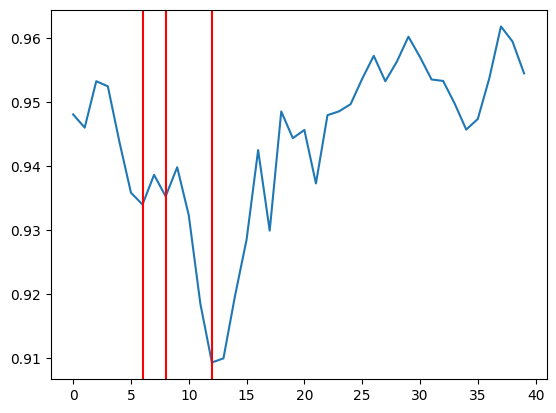

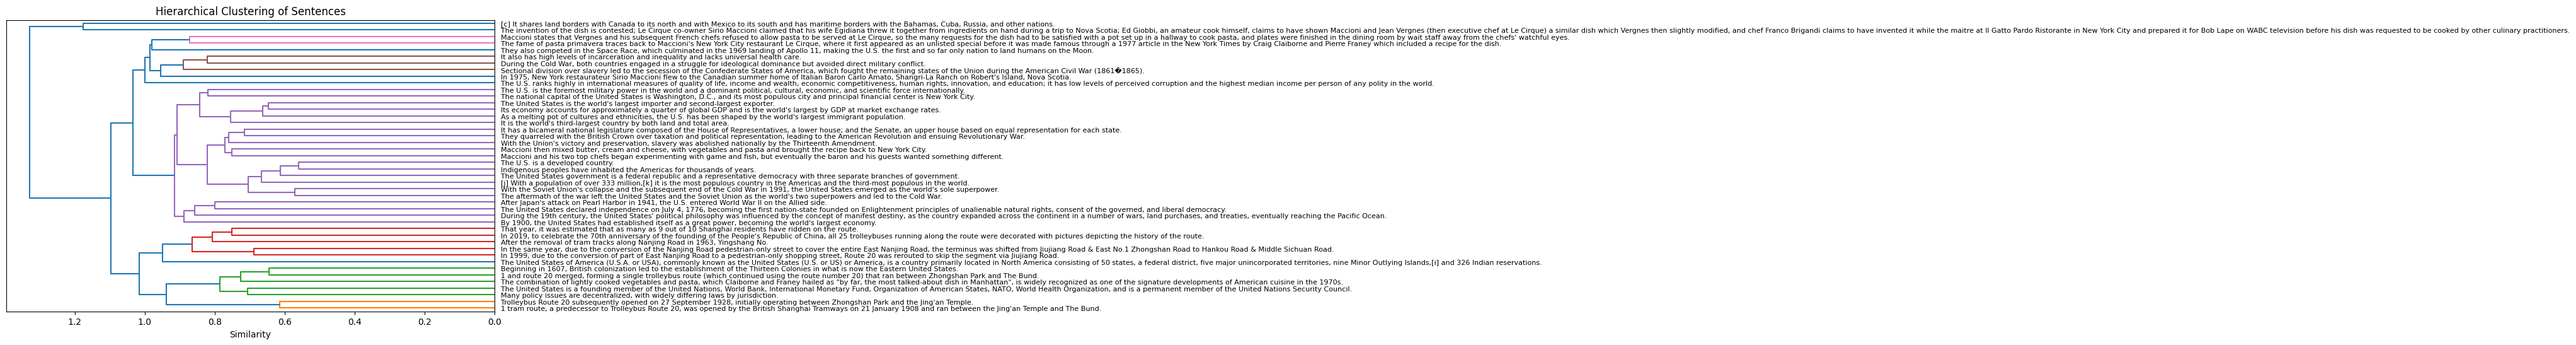

<Figure size 1000x1000 with 0 Axes>

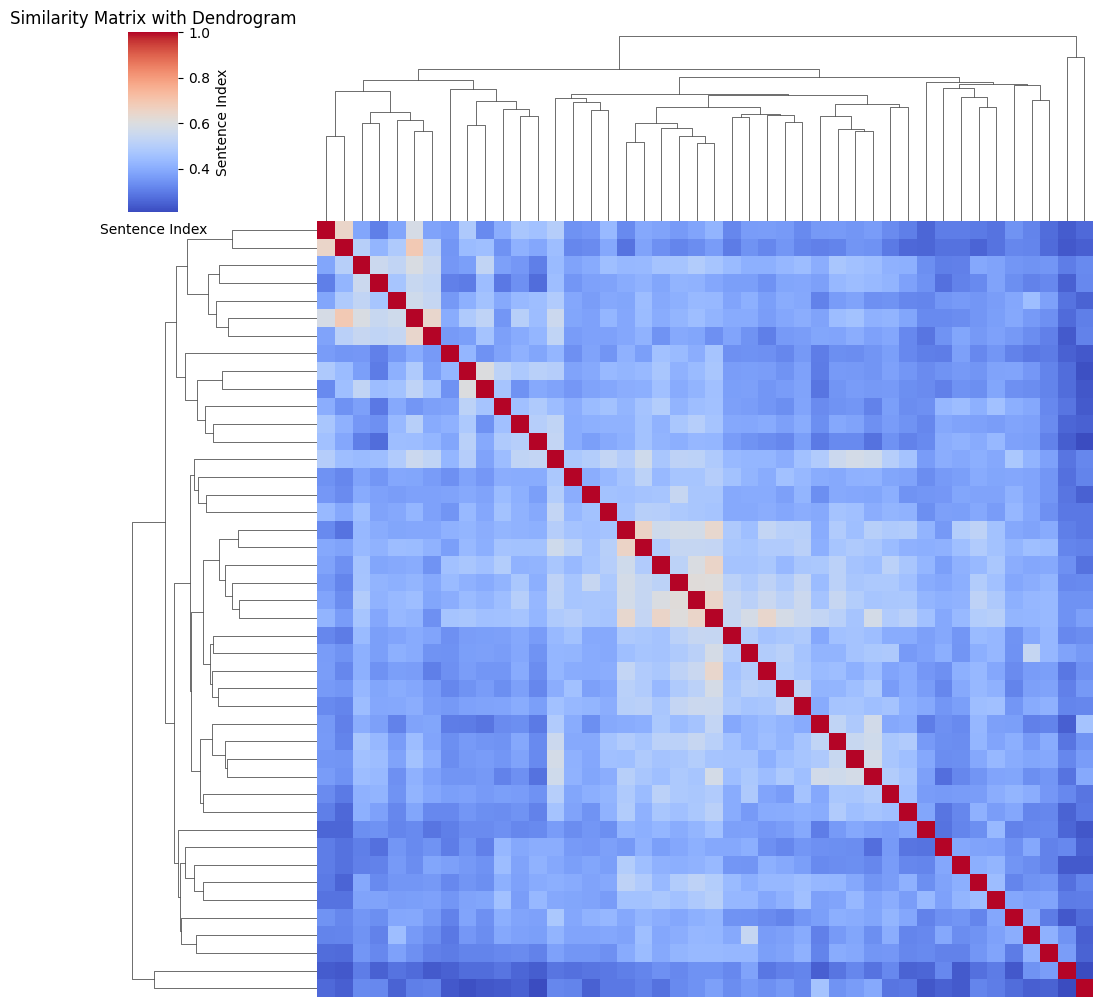

In [15]:
import os
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram


def read_article(path):
    sentences = []
    paragraphs = []
    real_indexes = []
    
    # Loop through each file in the path
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)

        # Read the content of the file
        with open(file_path, 'r', encoding='utf-8') as f:
            article = f.read()

        # Split the article into paragraphs
        splitted = article.split('\n')
        paragraphs.extend(splitted)

        # Track the index at which the files are merged
        real_indexes.append(len(splitted))

    # Calculate the cumulative sum of real indexes
    for i in range(1, len(real_indexes)):
        real_indexes[i] += real_indexes[i-1]

    # Rebuild the sentences by joining the paragraphs with '\n'
    paragraphs = [x for x in paragraphs if x.strip() != '']
    articles = '\n'.join(paragraphs)
    sentences = sent_tokenize(articles)

    return sentences, paragraphs, real_indexes

    
def print_segments(sentences, split_indexes, max_chars_per_row=80):
    segments = []
    current_start = 0
    
    for split_index in split_indexes:
        segment = " ".join(sentences[current_start:split_index]).strip()
        if segment:
            segments.append(segment)
        current_start = split_index
    
    last_segment = " ".join(sentences[current_start:]).strip()
    if last_segment:
        segments.append(last_segment)
    
    for segment in segments:
        # Split the segment into rows of maximum characters per row
        rows = [segment[i:i+max_chars_per_row] for i in range(0, len(segment), max_chars_per_row)]
        
        # Print each row with a separator
        print("\n".join(rows))
        print("---")

def plot_similarity(similarity_data, minimas):
    pd.Series(similarity_data).plot()
    for xc in minimas:
        plt.axvline(x=xc, color='red')
    plt.show()
    
    

# Main execution
def run(MAX_SPLITS,ARTICLE_PATH,WINDOW_SIZE_MULTIPLIER,EXCLUSION_ZONE,MORE_PLOTS):

    sentences, paragraphs, correct_indexes = read_article(ARTICLE_PATH)
    window_size = round(len(sentences)/len(paragraphs) * WINDOW_SIZE_MULTIPLIER)
    processed_sentences = [' '.join(preprocess(sentence, use_synsets=True).keys()) for sentence in sentences]
    similarity_matrix = compute_similarity_matrix(processed_sentences)

    similarity_data = compute_rolling_window_similarity(similarity_matrix, window_size=WINDOW_SIZE_MULTIPLIER)
    minimas = select_minimas(similarity_data, side_exclusion_zone_size=EXCLUSION_ZONE, max_splits=MAX_SPLITS)
    print("Total sentences",len(sentences))
    split_indexes = [index + floor(window_size / 2) for index in minimas]
    print(similarity_data)
    print("minimas",minimas)
    print("split_indexes", split_indexes)
    print("Real split",correct_indexes)
    print_segments(sentences, split_indexes)
    plot_similarity(similarity_data, minimas)

    if( MORE_PLOTS):
        # Hierarchical plot
        plt.figure(figsize=(10, 6))
        linkage_matrix = linkage(similarity_matrix, method='average', metric='euclidean')
        dendrogram(linkage_matrix, labels=sentences, orientation='left')
        plt.xlabel("Similarity")
        plt.title("Hierarchical Clustering of Sentences")
        plt.show()


        # Heatmap with dendrogram
        plt.figure(figsize=(10, 10))
        sns.clustermap(similarity_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
        plt.xlabel("Sentence Index")
        plt.ylabel("Sentence Index")
        plt.title("Similarity Matrix with Dendrogram")
        plt.show()
MAX_SPLITS = 3  # Set the maximum number of splits
ARTICLE_PATH = './articles'
WINDOW_SIZE_MULTIPLIER = 5           # Se 1 la finestra è grande quanto la dimensione media di un paragrafo
EXCLUSION_ZONE = 2 # number of tokens to skip matching on the left and on the right
MORE_PLOTS= True

run(MAX_SPLITS,ARTICLE_PATH,WINDOW_SIZE_MULTIPLIER,EXCLUSION_ZONE,MORE_PLOTS)



Total sentences 44
[0.9480753317612195, 0.9460133132296669, 0.9532760780398429, 0.9524771332906365, 0.9438060835773895, 0.9358337723405199, 0.9339806208123143, 0.9386315005770525, 0.9352642910743479, 0.9398178866648709, 0.9323039714827932, 0.9185002094961157, 0.9092753352993799, 0.9099187803156537, 0.9196888690221005, 0.928486768849553, 0.9424997564332084, 0.9299007876291846, 0.9485415038895729, 0.9443651502403685, 0.9456459316819102, 0.9372878560597164, 0.9479658312179916, 0.9485621200917992, 0.9496891928159361, 0.9536515607707546, 0.9572459209647518, 0.953270885501453, 0.9563374188899022, 0.9602432342012531, 0.9570566255807103, 0.9535450789081468, 0.953317655376593, 0.9497683606064518, 0.9457093166509735, 0.9473671364038696, 0.9537635025961285, 0.9618368487373562, 0.9594897996939276, 0.9545070168285055]
minimas [6, 8, 12, 17, 21]
split_indexes [8, 10, 14, 19, 23]
Real split [8, 15, 44]
1 tram route, a predecessor to Trolleybus Route 20, was opened by the British Sh
anghai Tramways on

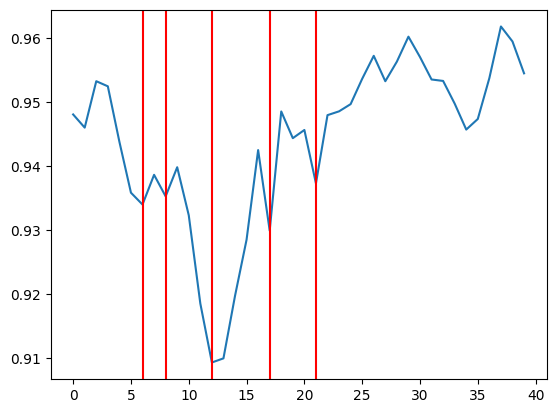

In [16]:
import os
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram


def read_article(path):
    sentences = []
    paragraphs = []
    real_indexes = []
    
    # Loop through each file in the path
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)

        # Read the content of the file
        with open(file_path, 'r', encoding='utf-8') as f:
            article = f.read()

        # Split the article into paragraphs
        splitted = article.split('\n')
        paragraphs.extend(splitted)

        # Track the index at which the files are merged
        real_indexes.append(len(splitted))

    # Calculate the cumulative sum of real indexes
    for i in range(1, len(real_indexes)):
        real_indexes[i] += real_indexes[i-1]

    # Rebuild the sentences by joining the paragraphs with '\n'
    paragraphs = [x for x in paragraphs if x.strip() != '']
    articles = '\n'.join(paragraphs)
    sentences = sent_tokenize(articles)

    return sentences, paragraphs, real_indexes

    
def print_segments(sentences, split_indexes, max_chars_per_row=80):
    segments = []
    current_start = 0
    
    for split_index in split_indexes:
        segment = " ".join(sentences[current_start:split_index]).strip()
        if segment:
            segments.append(segment)
        current_start = split_index
    
    last_segment = " ".join(sentences[current_start:]).strip()
    if last_segment:
        segments.append(last_segment)
    
    for segment in segments:
        # Split the segment into rows of maximum characters per row
        rows = [segment[i:i+max_chars_per_row] for i in range(0, len(segment), max_chars_per_row)]
        
        # Print each row with a separator
        print("\n".join(rows))
        print("---")

def plot_similarity(similarity_data, minimas):
    pd.Series(similarity_data).plot()
    for xc in minimas:
        plt.axvline(x=xc, color='red')
    plt.show()
    
    

# Main execution
def run(MAX_SPLITS,ARTICLE_PATH,WINDOW_SIZE_MULTIPLIER,EXCLUSION_ZONE,MORE_PLOTS):

    sentences, paragraphs, correct_indexes = read_article(ARTICLE_PATH)
    window_size = round(len(sentences)/len(paragraphs) * WINDOW_SIZE_MULTIPLIER)
    processed_sentences = [' '.join(preprocess(sentence, use_synsets=True).keys()) for sentence in sentences]
    similarity_matrix = compute_similarity_matrix(processed_sentences)

    similarity_data = compute_rolling_window_similarity(similarity_matrix, window_size=WINDOW_SIZE_MULTIPLIER)
    minimas = select_minimas_normal(similarity_data, side_exclusion_zone_size=EXCLUSION_ZONE)
    print("Total sentences",len(sentences))
    split_indexes = [index + floor(window_size / 2) for index in minimas]
    print(similarity_data)
    print("minimas",minimas)
    print("split_indexes", split_indexes)
    print("Real split",correct_indexes)
    print_segments(sentences, split_indexes)
    plot_similarity(similarity_data, minimas)

    if( MORE_PLOTS):
        # Hierarchical plot
        plt.figure(figsize=(10, 6))
        linkage_matrix = linkage(similarity_matrix, method='average', metric='euclidean')
        dendrogram(linkage_matrix, labels=sentences, orientation='left')
        plt.xlabel("Similarity")
        plt.title("Hierarchical Clustering of Sentences")
        plt.show()


        # Heatmap with dendrogram
        plt.figure(figsize=(10, 10))
        sns.clustermap(similarity_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
        plt.xlabel("Sentence Index")
        plt.ylabel("Sentence Index")
        plt.title("Similarity Matrix with Dendrogram")
        plt.show()
MAX_SPLITS = 2  # Set the maximum number of splits
ARTICLE_PATH = './articles'
WINDOW_SIZE_MULTIPLIER = 5           # Se 1 la finestra è grande quanto la dimensione media di un paragrafo
EXCLUSION_ZONE = 2 # number of tokens to skip matching on the left and on the right
MORE_PLOTS= False

run(MAX_SPLITS,ARTICLE_PATH,WINDOW_SIZE_MULTIPLIER,EXCLUSION_ZONE,MORE_PLOTS)



### Risultati
I risultati ottenuti possono essere considerati un 
primo risultato che sicuramente è moolto migliorabile ma che comunque riesce a suddividere in modo un po’ 
grossolano i vari contesti. 

Sia la versione "vincolata" del "select_minimas" dove indico il numero massimo di tagli da eseguire (max split) sia la versione 'libera' che genera tutti i tagli, si sono avvicinati considerevolmente al taglio reale. La matrice di similarità tra frasi può contenere valori molto prossimi allo zero ed in genere è molto sparsa e sicuramente ciò non aiuta a livello di utilizzo di memoria.

Si può notare che in entrambi i casi, il secondo ed il terzo testo hanno effettivamente degli overlap semantici, in quanto trattano di città americane e questo è probabilmente il motivo per cui è stato eseguito il taglio 4-5 frasi in anticipo.

Possibili miglioramenti: ridefinizione delle funzioni di calcolo della distanza, e soprattuto del concetto di window (gestito il modo molto banale). Sicuramente adottando un vero e proprio algoritmo di clustering si sarebbero notate differenze piu grandi anche a livello di dendogramma. 